In [1]:
import os
workdir = "datasets/Project/"        
os.chdir(workdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
def loaddata(path, seed=9527):
    """
    Usage: there should be ./breast/ and ./prostate/ under the path
    """
    
    np.random.seed(seed=seed)
    
    def image2tensor(tumor, cnv):
        train1, train2, train3, testset1, testset2, testset3 = [], [], [], [], [], []
        train = [train1, train2, train3] # 3 channels
        test = [testset1, testset2, testset3]

        rawfnames = !ls ./$tumor/$cnv/*jpg
        rawfnames = np.array(np.sort(rawfnames), dtype=object)
        
        # randomly distribute data to train set and test set in 5:1 ratio
        randomIndices = np.random.permutation(rawfnames.shape[0]//3)
        for i, rawf in enumerate(rawfnames):
            im = cv2.imread(rawf, 0)
            channel = i % 3
            if (randomIndices[i//3]) % 6 == 0:
                test[channel].append(im)
            else:
                train[channel].append(im)
                
        return np.array(train).transpose([1,2,3,0]), np.array(test).transpose([1,2,3,0])
    
    tumors = ["breast", "prostate"]
    cnvs = ["altered", "flat"]
    
    trainset,  testset = {"breast" : {}, "prostate" : {}}, {"breast" : {}, "prostate" : {}}
    data = {"trainset" : trainset , "testset" : testset}
    
    for tumor in tumors:
        for i, cnv in enumerate(cnvs):
            if i == 0:
                trainset[tumor]["pos"], testset[tumor]["pos"] = image2tensor(tumor, cnv)
            if i == 1:
                trainset[tumor]["neg"], testset[tumor]["neg"] = image2tensor(tumor, cnv)
                
    return data

trainset breast pos (484, 225, 225, 3)
trainset breast neg (455, 225, 225, 3)
trainset prostate pos (323, 225, 225, 3)
trainset prostate neg (285, 225, 225, 3)
testset breast pos (97, 225, 225, 3)
testset breast neg (92, 225, 225, 3)
testset prostate pos (65, 225, 225, 3)
testset prostate neg (58, 225, 225, 3)


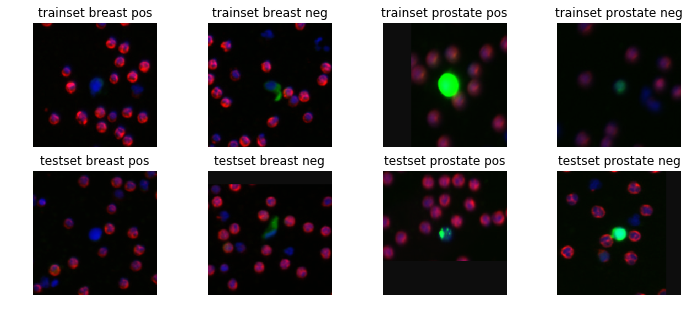

In [3]:
data = loaddata(workdir)

fig, axes = plt.subplots(2,4, figsize=(12,5))
i, j = 0, 0

for subset, d1 in data.items():
    for tumor, d2 in d1.items():
        for cnv, imgs in d2.items():
            print("{} {} {} {}".format(subset, tumor, cnv, imgs.shape))
            axes[i,j%4].imshow(data[subset][tumor][cnv][0])
            axes[i,j%4].set_title("{} {} {}".format(subset, tumor, cnv))
            axes[i,j%4].axis('off')
            j += 1
    i += 1

plt.show()
plt.close()

# Naive CNN with Batch Normalization

* Not using any data preprocessing or augmentation
* Adding BatchNorm after every ReLU activation

## 1. Breast Cancer

In [4]:
tumor = "breast"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 3
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 939 samples, validate on 189 samples
Epoch 1/3
939/939 [==============================] - 168s 179ms/step - loss: 0.7063 - acc: 0.7753 - val_loss: 0.9750 - val_acc: 0.7513
Epoch 2/3
939/939 [==============================] - 164s 175ms/step - loss: 0.3215 - acc: 0.8839 - val_loss: 0.8019 - val_acc: 0.7407
Epoch 3/3
189/189 [==============================] - 8s 42ms/step
Test loss: 0.8286747850438274
Test accuracy: 0.7513227532149622


In [6]:
# Save model and weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_breast.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/zifanzhu/Desktop/DL_project/datasets/Project/saved_models/naive_cnn_with_batchnorm_breast.h5 


## 2. Prostate Cancer

In [4]:
tumor = "prostate"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 3
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 608 samples, validate on 123 samples
Epoch 1/3
608/608 [==============================] - 209s 344ms/step - loss: 0.8720 - acc: 0.6628 - val_loss: 0.8856 - val_acc: 0.7073
Epoch 2/3
608/608 [==============================] - 110s 181ms/step - loss: 0.3437 - acc: 0.8487 - val_loss: 0.6977 - val_acc: 0.7724
Epoch 3/3
123/123 [==============================] - 5s 41ms/step
Test loss: 0.7554102537593221
Test accuracy: 0.7479674811285686


In [6]:
# Save model and weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_prostate.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/zifanzhu/Desktop/DL_project/datasets/Project/saved_models/naive_cnn_with_batchnorm_prostate.h5 


## 3. Model transfer: prostate model test on breast

In [7]:
from keras.models import load_model
import keras

# load trained model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_prostate.h5'
model_path = os.path.join(save_dir, model_name)

del model
model = load_model(model_path)

In [8]:
tumor = "breast"

xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))
y_test = keras.utils.to_categorical(y_test, 2)

In [9]:
# evaluate on test set

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

189/189 [==============================] - 9s 46ms/step
Test loss: 0.7713835504319932
Test accuracy: 0.7089947080486035


## 4. Model transfer: breast model test on prostate

In [7]:
from keras.models import load_model
import keras

# load trained model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_breast.h5'
model_path = os.path.join(save_dir, model_name)

del model
model = load_model(model_path)

In [8]:
tumor = "prostate"

xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))
y_test = keras.utils.to_categorical(y_test, 2)

In [9]:
# evaluate on test set

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

123/123 [==============================] - 6s 48ms/step
Test loss: 1.0489666206323034
Test accuracy: 0.7235772406182638


## 5. Summary

* Both dataset can achieve about 0.75 accuracy.
* Model transfer cannot improve accuracy.